In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

IS_HK = 1
IS_NOT_HK = 0

%matplotlib inline

In [2]:
data = pd.read_csv("data.csv")
data.head()

,EMBL_transcript_id,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
0,ENST00000274311,2918.0,1158.0,3.0,no,no,no,yes,0.1,0.200000,NaN
1,ENST00000282588,4795.0,3540.0,29.0,no,no,no,yes,0.1,0.200000,NaN
2,ENST00000274311,2918.0,1158.0,3.0,no,no,no,yes,0.1,0.200000,NaN
3,ENST00000282588,4795.0,3540.0,29.0,no,no,no,yes,0.1,0.200000,NaN
4,ENST00000337416,4551.0,1656.0,18.0,no,yes,no,no,0.0,0.111111,NaN


In [3]:
data.describe()

,cDNA_length,cds_length,exons_nr,perc_go_hk_match,perc_go_ts_match
count,35164.000000,35164.000000,20568.000000,25957.000000,25957.000000
mean,2439.950432,1484.058583,6.568748,0.036278,0.222914
std,2012.944961,1502.566846,8.333126,0.131669,0.253348
min,45.000000,45.000000,1.000000,0.000000,0.000000
25%,1168.000000,642.000000,1.000000,0.000000,0.000000
50%,2047.000000,1119.000000,3.000000,0.000000,0.166667
75%,3185.250000,1821.000000,9.000000,0.000000,0.363636
max,99631.000000,98385.000000,118.000000,1.000000,1.000000


In [4]:
data.loc[data["5_MAR_presence"] == "no", "5_MAR_presence"] = 0.0
data.loc[data["5_MAR_presence"] == "yes", "5_MAR_presence"] = 1.0
data.loc[data["3_MAR_presence"] == "no", "3_MAR_presence"] = 0.0
data.loc[data["3_MAR_presence"] == "yes", "3_MAR_presence"] = 1.0
data.loc[data["5_polyA_18_presence"] == "no", "5_polyA_18_presence"] = 0.0
data.loc[data["5_polyA_18_presence"] == "yes", "5_polyA_18_presence"] = 1.0
data.loc[data["5_CCGNN_2_5_presence"] == "no", "5_CCGNN_2_5_presence"] = 0.0
data.loc[data["5_CCGNN_2_5_presence"] == "yes", "5_CCGNN_2_5_presence"] = 1.0
data.loc[data["is_hk"] == "no", "is_hk"] = 0.0
data.loc[data["is_hk"] == "yes", "is_hk"] = 1.0
del data["EMBL_transcript_id"]

data["5_MAR_presence"] = data["5_MAR_presence"].astype(float)
data["3_MAR_presence"] = data["3_MAR_presence"].astype(float)
data["5_polyA_18_presence"] = data["5_polyA_18_presence"].astype(float)
data["5_CCGNN_2_5_presence"] = data["5_CCGNN_2_5_presence"].astype(float)

category_features = ["5_MAR_presence", "3_MAR_presence", "5_polyA_18_presence", "5_CCGNN_2_5_presence"]

In [5]:
data.head()

,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
0,2918.0,1158.0,3.0,0.0,0.0,0.0,1.0,0.1,0.200000,NaN
1,4795.0,3540.0,29.0,0.0,0.0,0.0,1.0,0.1,0.200000,NaN
2,2918.0,1158.0,3.0,0.0,0.0,0.0,1.0,0.1,0.200000,NaN
3,4795.0,3540.0,29.0,0.0,0.0,0.0,1.0,0.1,0.200000,NaN
4,4551.0,1656.0,18.0,0.0,1.0,0.0,0.0,0.0,0.111111,NaN


- How many items are NaN in the is hk column?
- How many items are known housekeeping genes?
- How many items are known tissue specific genes?

In [6]:
print("NaN %s" % len(data[data["is_hk"].isnull()]))
print("Housekeeping %s" % len(data[data["is_hk"] == 1]))
print("Specific %s" % len(data[data["is_hk"] == 0]))

NaN 46459
Housekeeping 103
Specific 667


In [7]:
def split_train_test(data):
    split = (int) (len(data) * 0.9)
    return data[0:split], data[split:]

def split_data(data):
    # Shuffle data
    data = data.sample(frac = 1)
    
    # train_set, test_set
    hk_yes = data[data["is_hk"] == IS_HK]
    hk_no = data[data["is_hk"] == IS_NOT_HK]
    
    train_yes, test_yes = split_train_test(hk_yes)
    train_no , test_no  = split_train_test(hk_no)
    
    train_set = train_yes
    train_set = train_set.append(train_no)
    train_set = train_set.sample(frac = 1)
    
    test_set = test_yes
    test_set = test_set.append(test_no)
    test_set = test_set.sample(frac = 1)
    
    # unsup_train_set
    unsup_train_set = data[data["is_hk"].isnull()]
    
    # sup_train_set
    sup_train_set = data[data["is_hk"].notnull()]
    
    return train_set, test_set, unsup_train_set, sup_train_set

train_set, test_set, unsup_train_set, sup_train_set = split_data(data)

In [8]:
def bin_plot(hist, bin_edge):
    # make sure to import matplotlib.pyplot as plt
    # plot the histogram
    plt.figure(figsize=(6,4))
    plt.fill_between(bin_edge.repeat(2)[1:-1],hist.repeat(2),facecolor="steelblue")
    plt.show()
    
    # plot the first 100 bins only
    plt.figure(figsize=(6,4))
    plt.fill_between(bin_edge.repeat(2)[1:100],hist.repeat(2)[1:100],facecolor="steelblue")
    plt.show()
    # plot the first 500 bins only
    plt.figure(figsize=(6,4))
    plt.fill_between(bin_edge.repeat(2)[1:500],hist.repeat(2)[1:500],facecolor="steelblue")
    plt.show()

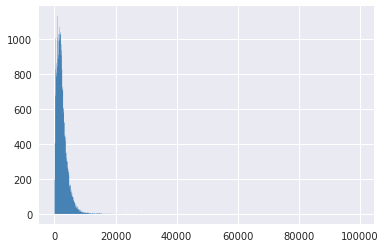

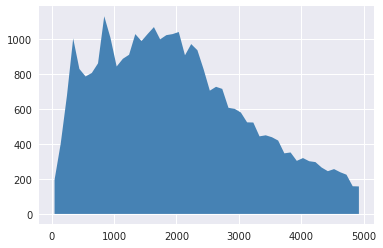

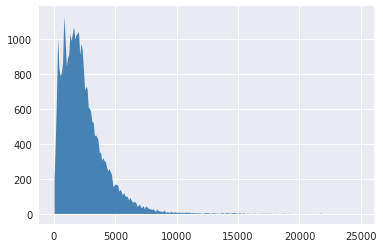

In [9]:
# remove NaN values
train_set_clength_no_nan = data["cDNA_length"][~np.isnan(data["cDNA_length"])]
# bin the data into 1000 equally spaced bins
# hist is the count for each bin
# bin_edge is the edge values of the bins
hist, bin_edge = np.histogram(train_set_clength_no_nan,1000)
bin_plot(hist, bin_edge)

How many bins have zero counts?

In [10]:
print("Total %s" % len(hist))
print("Zeros %s" % sum(hist == 0))

Total 1000
Zeros 823


**cDNA Density Plot**

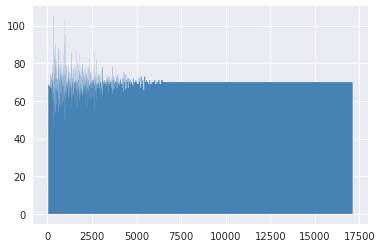

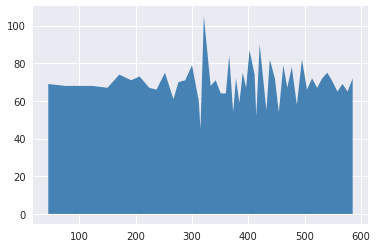

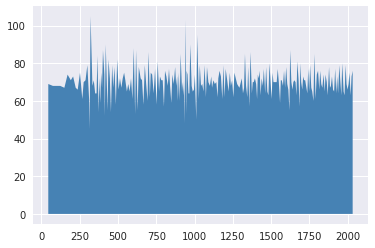

In [11]:
train_set_clength_no_nan_sorted = data["cDNA_length"][data["cDNA_length"].notnull()].sort_values()

bin_edge = np.unique(train_set_clength_no_nan_sorted[0::70])
hist = np.bincount(np.digitize(train_set_clength_no_nan_sorted, bin_edge))
hist = hist[1:-1]
bin_plot(hist, bin_edge)

**CDS Density Plot**

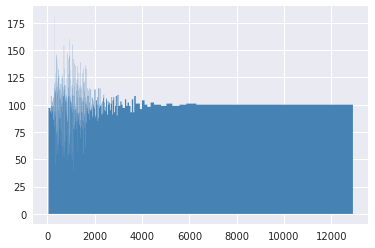

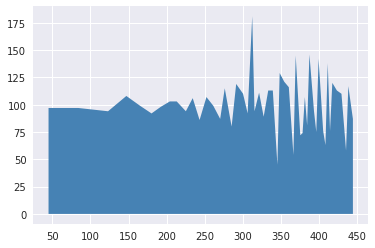

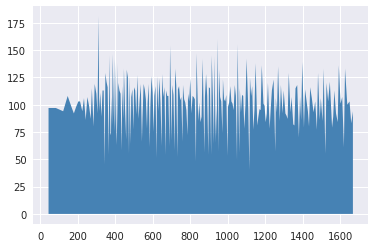

In [12]:
train_set_clength_no_nan_sorted = data["cds_length"][data["cds_length"].notnull()].sort_values().values

bin_edge = np.unique(train_set_clength_no_nan_sorted[0::100])
hist = np.bincount(np.digitize(train_set_clength_no_nan_sorted, bin_edge))
hist = hist[1:-1]
bin_plot(hist, bin_edge)

## Plot Raw Data

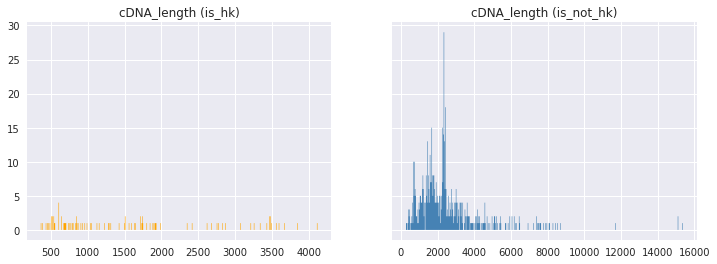

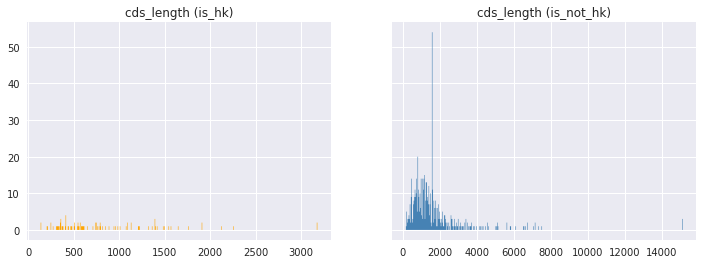

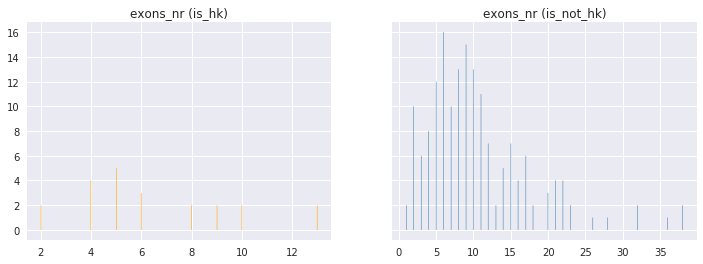

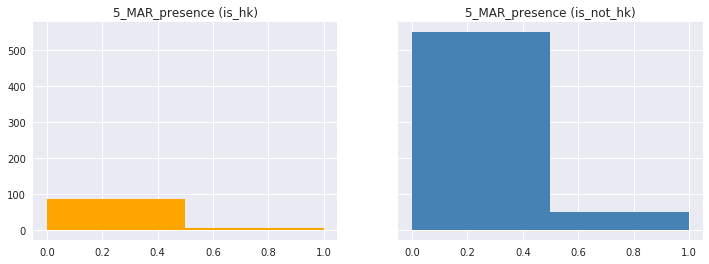

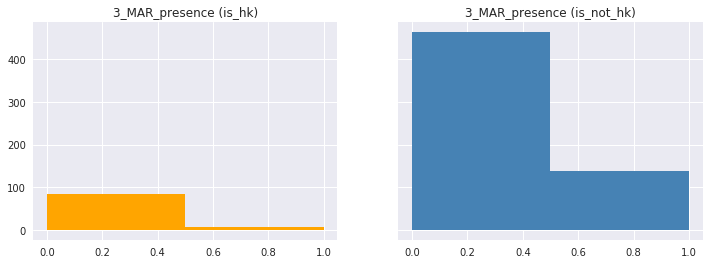

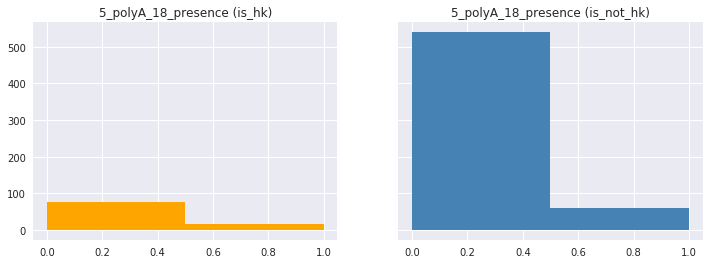

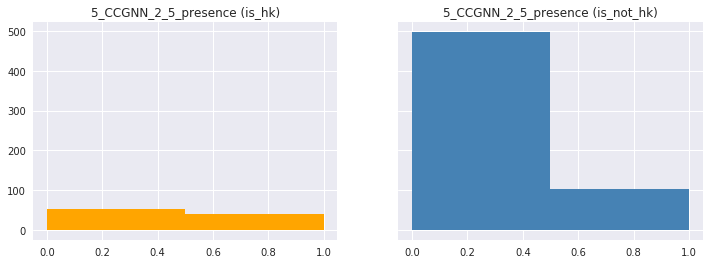

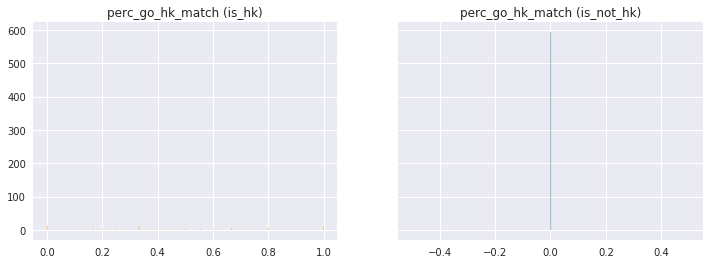

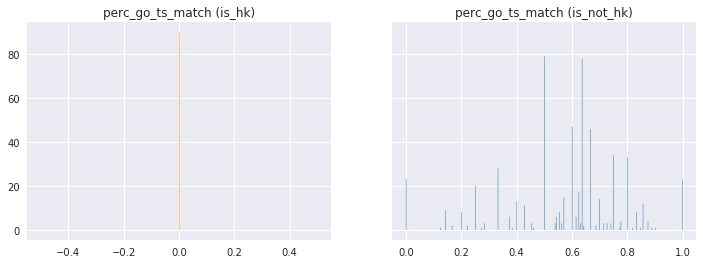

In [13]:
for feature in list(train_set):
    if feature == "is_hk":
        continue
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
    
    bin_size = 2 if feature in category_features else 500
        
    X = train_set[train_set["is_hk"] == IS_HK][feature][~np.isnan(train_set[feature])]
    hist, bin_edge = np.histogram(X, bin_size)
    ax1.fill_between(bin_edge.repeat(2)[1:-1],hist.repeat(2),facecolor="orange")
    ax1.set_title(feature + " (is_hk)")
    
    X = train_set[train_set["is_hk"] == IS_NOT_HK][feature][~np.isnan(train_set[feature])]
    hist, bin_edge = np.histogram(X, bin_size)
    ax2.fill_between(bin_edge.repeat(2)[1:-1],hist.repeat(2),facecolor="steelblue")
    ax2.set_title(feature + " (is_not_hk)")
    
    plt.show()

## MLE Distribution

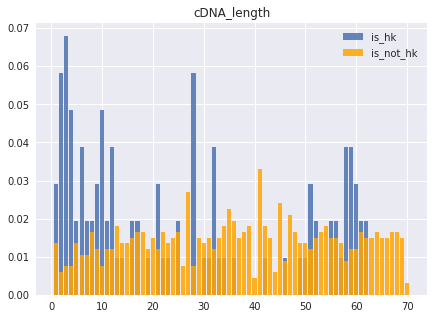

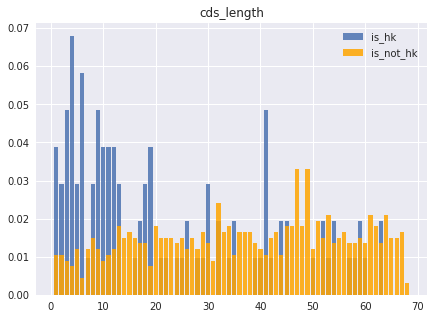

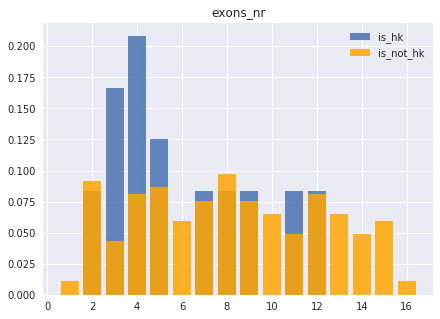

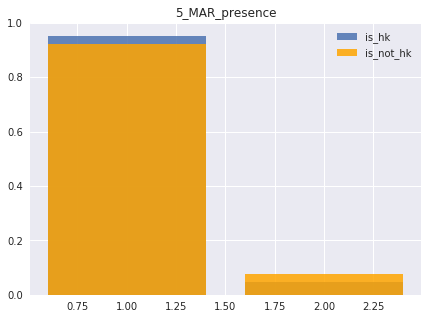

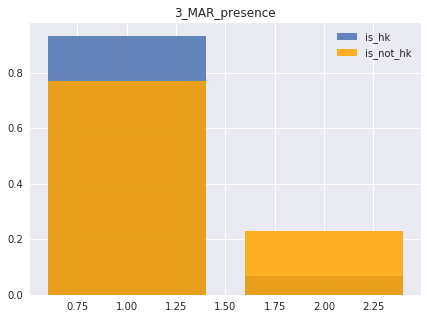

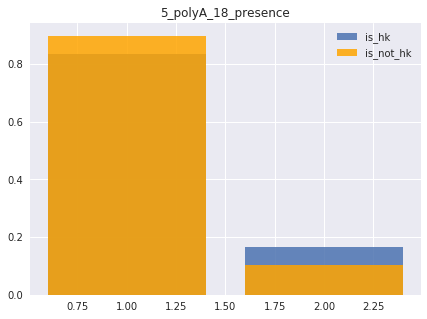

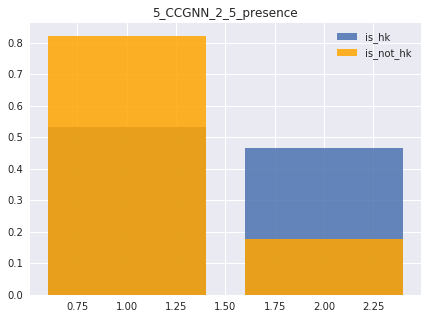

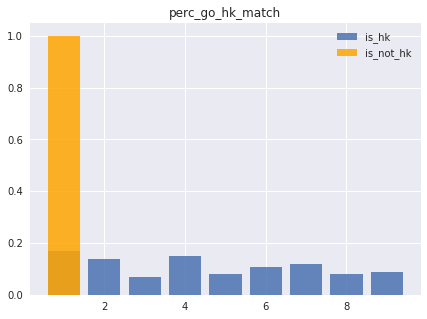

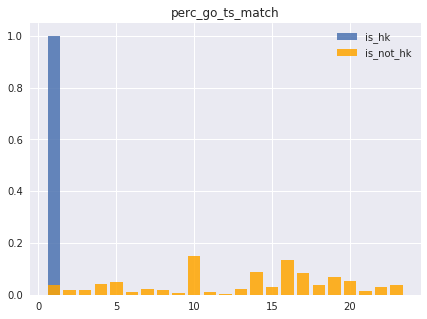

In [14]:
mle_dist = {}

def bin_data_likelihood(train, sup_train, feature):
    data = train[feature][train[feature].notnull()].sort_values()
    
    bin_edge = np.unique(data[0::10])
    
    sup_train = sup_train[sup_train[feature].notnull()]
    sup_train_is_hk = sup_train[feature][sup_train["is_hk"] == 1]
    sup_train_is_not_hk = sup_train[feature][sup_train["is_hk"] == 0]
    hist_is_hk = np.bincount(np.digitize(sup_train_is_hk, bin_edge))
    hist_is_not_hk = np.bincount(np.digitize(sup_train_is_not_hk, bin_edge))
    
    hist_is_hk = hist_is_hk / len(sup_train_is_hk)
    hist_is_not_hk = hist_is_not_hk / len(sup_train_is_not_hk)
    
    hist_is_hk = np.append(hist_is_hk, np.zeros(len(bin_edge) + 1 - len(hist_is_hk)))
    hist_is_not_hk = np.append(hist_is_not_hk, np.zeros(len(bin_edge) + 1 - len(hist_is_not_hk)))
    
    return bin_edge, hist_is_hk, hist_is_not_hk

for feature in list(train_set):
    if feature == "is_hk":
        continue
    
    bin_edge, hist_hk, hist_not_hk = bin_data_likelihood(train_set, sup_train_set, feature)
    
    data = {
        "bin_edge": bin_edge,
        "is_hk": hist_hk,
        "is_not_hk": hist_not_hk
    }
    mle_dist[feature] = data

    plt.figure(figsize=(7,5))
    plt.bar(np.arange(1, len(bin_edge) + 1), hist_hk[1:], alpha=0.85)
    plt.bar(np.arange(1, len(bin_edge) + 1), hist_not_hk[1:], alpha=0.85, color="orange")
    plt.legend(["is_hk", "is_not_hk"])
    plt.title(feature)
    plt.show()

Find Prior

In [15]:
prior = [0, 0]
prior[IS_HK] = len(sup_train_set[sup_train_set["is_hk"] == IS_HK]) / len(sup_train_set)
prior[IS_NOT_HK] = len(sup_train_set[sup_train_set["is_hk"] == IS_NOT_HK]) / len(sup_train_set)
print("Prior is_hk = %f, is_not_hk = %f" % (prior[IS_HK], prior[IS_NOT_HK]))

Prior is_hk = 0.133766, is_not_hk = 0.866234


## MLE Prediction

In [16]:
def prob_category(x, ll, is_hk):
    if x == 0:
        return ll[is_hk]["prob_zero"]
    else:
        return 1 - ll[is_hk]["prob_zero"]

def predict(test_data):
    global mle_dist
    
    L = np.zeros(len(test_data))
    for feature in list(test_data):
        
        if feature == "is_hk":
            continue
        
        data = test_data[feature]
        not_null_idx = data.notnull()
        
        p_house = mle_dist[feature]["is_hk"][np.digitize(data, mle_dist[feature]["bin_edge"])]
        p_not_house = mle_dist[feature]["is_not_hk"][np.digitize(data, mle_dist[feature]["bin_edge"])]
        
        L[not_null_idx] += np.log(p_house[not_null_idx] + 0.01)
        L[not_null_idx] -= np.log(p_not_house[not_null_idx] + 0.01)
            
    L += np.log(prior[IS_HK]) - np.log(prior[IS_NOT_HK])
    
    return L

In [17]:
def activate_predict(y, threshold = 0.0):
    return (y > threshold).astype(int)

In [18]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

def precision(y_test, y_pred):
    n_y_pred = np.sum(y_pred == 1)
    return np.sum(np.logical_and(y_test == y_pred, y_pred == 1)) / (np.sum(y_pred == 1) + 1e-12)
    
# true positive rate
def recall(y_test, y_pred):
    return np.sum(np.logical_and(y_test == y_pred, y_test == 1)) / (np.sum(y_test == 1) + 1e-12)

def false_positive_rate(y_test, y_pred):
    return np.sum(np.logical_and(y_test != y_pred, y_test == 0)) / np.sum(y_test == 0)

def measure_metrics(y_test, y_pred):
    print("Accuracy: %f" % accuracy(y_test, y_pred))
    pcs = precision(y_test, y_pred)
    rc = recall(y_test, y_pred)
    print("Precision: %f" % pcs)
    print("Recall: %f" % rc)
    f1 = 2 * pcs * rc / (pcs + rc + 1e-12)
    print("F1: %f" % f1)

In [19]:
y_test = test_set["is_hk"]
y_pred = activate_predict(predict(test_set))
measure_metrics(y_test, y_pred)

Accuracy: 0.987179
Precision: 0.916667
Recall: 1.000000
F1: 0.956522


## Baseline

1\. Random Choice Baseline

In [20]:
def create_random_pred():
    return np.random.random_sample((len(y_test),)) - 0.5
y_pred = activate_predict(create_random_pred())
measure_metrics(y_test, y_pred)

Accuracy: 0.525641
Precision: 0.175000
Recall: 0.636364
F1: 0.274510


2\. Majority

In [21]:
def create_majority_pred():
    return np.ones(len(y_test)) * test_set["is_hk"].mode().values.astype(int)
y_pred = create_majority_pred()
measure_metrics(y_test, y_pred)

Accuracy: 0.858974
Precision: 0.000000
Recall: 0.000000
F1: 0.000000


## ROC

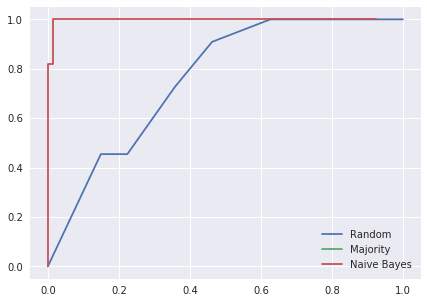

In [22]:
t = np.arange(-10,10,0.1)

tp = []
tp_random = []
tp_majority = []

fp = []
fp_random = []
fp_majority = []

y_test = test_set["is_hk"]

y_pred = predict(test_set)
y_random = create_random_pred()
y_act_majority = create_majority_pred()

for t_i in t:
    
    y_act_pred = activate_predict(y_pred, threshold = t_i)
    y_act_random = activate_predict(y_random, threshold = t_i)
    
    tp.append(recall(y_test, y_act_pred))
    fp.append(false_positive_rate(y_test, y_act_pred))
    
    tp_random.append(recall(y_test, y_act_random))
    fp_random.append(false_positive_rate(y_test, y_act_random))
    
    tp_majority.append(recall(y_test, y_act_majority))
    fp_majority.append(false_positive_rate(y_test, y_act_majority))
    
plt.figure(figsize=(7,5))
plt.plot(fp_random, tp_random)
plt.plot(fp_majority, tp_majority)
plt.plot(fp, tp)
plt.legend(['Random', 'Majority', 'Naive Bayes'])
plt.show()